In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, multiprocessing as mp
from numpy import random
import torch, cv2, time, random, os, threading, pickle

In [60]:
DTYPE = {
    'boolean': torch.bool, 'ui8': torch.uint8, 'i8': torch.int8, 'i16': torch.int16, 'i32': torch.int32, 'i64': torch.int64, 
    'f16': torch.float16, 'f32': torch.float32, 'f64': torch.float64, 'f64Complex': torch.complex64, 'f128Complex': torch.complex128
}
DEVICE = {
    'auto': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), 
    'cpu': torch.device('cpu'), 
    'cuda0': torch.device('cuda:0')
}

DEVICE_CHOICE = 'auto'

In [117]:
class DNN(object):
    def __init__(self, layers=(10, 20, 10), aFunc=('cos', 'PRelu', 'PRelu', 'sin')):
        self.layerNum = len(layers)
        assert self.layerNum >= 1
        torch.manual_seed(0)
        self.backProp = {
            'PRelu': True,  # 如果False, 则 == Leaky Relu
            'Norm': True
        }
        self.paramLimits = {
            'weights': (-10000000, 10000000), 
            'biases': (-10000000, 10000000), 
            'relu param': (-100, 100), 
            'BN gamma': (-1000, 1000), 
            'BN beta': (-1000, 1000), 
            'dW': (-1, 1), 
            'dB': (-10, 10), 
            'dReluP': (-10, 10), 
            'dGamma': (-10, 10), 
            'dBeta': (-10, 10)
        }
        self.layerShapes = layers
        self.aFuncChosen = aFunc
        self.defaultLr = 0.00001
        self.lr = {
            'weight': self.defaultLr * 250,
            'bias': self.defaultLr * 5000,
            'relu param': self.defaultLr * 10, 
            'BN gamma': self.defaultLr, 
            'BN beta': self.defaultLr
        }
        self.inputs = None
        self.targetY = None
        self.weights = [None] * self.layerNum
        self.biases = [None] * self.layerNum
        self.reluParam = [0.01] * self.layerNum
        self.layers = {
            'Z': [None] * self.layerNum, 
            'N': [None] * self.layerNum, 
            'A': [None] * self.layerNum
        }
        self.BN = {
            'epsilon': 1e-5, 
            'gamma': [1] * self.layerNum, 
            'beta': [0] * self.layerNum, 
            'cache': [None] * self.layerNum
        }
        self.activFunc = {
            'PRelu': lambda x, i: torch.max(x, x * self.reluParam[i]), 
            'sigmoid': lambda x: 1/(1+torch.exp(-x)), 
            'softmax': lambda x: torch.exp(x - torch.max(x)) / torch.sum(torch.exp(x - torch.max(x))), 
            'tanh': lambda x: torch.tanh(x), 
            'sin': lambda x: torch.sin(x), 
            'cos': lambda x: torch.cos(x), 
            'linear': lambda x: x
        }
        self.activFuncDer = {
            'PRelu': self._PReluDer,  
            'sigmoid': lambda x: self.activFunc['sigmoid'](x) * (1 - self.activFunc['sigmoid'](x)), 
            'softmax': lambda x, a: self.activFunc['softmax'](x) * (a - self.activFunc['softmax'](x)), 
            'tanh': lambda x: 1 - torch.tanh(x) ** 2, 
            'sin': lambda x: torch.cos(x), 
            'cos': lambda x: -torch.sin(x), 
            'linear': lambda x: 1
        }
        self.lossFunc = {
            'mse': lambda predictY, targetY: (targetY - predictY) ** 2, 
            'bce': lambda predictY, targetY: targetY * torch.log(predictY) + (1 - targetY) * torch.log(1 - predictY)
        }
        self.lossFuncDer = {
            'mse': lambda predictY, targetY: 2 * (targetY - predictY), 
            'bce': lambda predictY, targetY: Y / predictY + (targetY - 1) / (1 - predictY)
        }
    
    def _dA_dReluP(self, x, i):
        data = x.clone()
        data[data > 0] = 0
        data[data <= 0] = torch.mean(data[data <= 0])
        return data
    
    def _PReluDer(self, x, i): 
        data = x.clone()
        data[data > 0] = 1
        data[data <= 0] = self.reluParam[i]
        return data
    
    def setBackProp(self, **kwargs):
        '''
        Keys: PRelu, Norm
        Values: True, False
        '''
        for k, v in kwargs.items():
            try:
                self.backProp[k] = v
            except:
                continue
            
    def batchNorm(self, x, layerIter):
        mean = torch.mean(x)
        variance = torch.mean((x - mean) ** 2)
        # normalize
        fenzi = (x - mean) * 1.0
        fenmu = torch.sqrt(variance + self.BN['epsilon'])
        # * 1.0 是转换成float
        xNorm = fenzi / fenmu
        cache = {
            'BNmean': mean, 
            'BNvariance': variance, 
            'BNfenzi': fenzi, 
            'BNfenmu': fenmu
        }
        self.BN['cache'][layerIter] = cache
        return self.BN['gamma'][layerIter] * xNorm + self.BN['beta'][layerIter]
    
    def setToLimit(self, data, limits):
        x = data.clone()
        x[x<limits[0]] = limits[0]
        x[x>limits[1]] = limits[1]
        return x
    
    # 生成 w、b, 以x的形状是 m x 1
    def genParam(self, x):
        self.inputs = x
        column = x.shape[0]
        for i, r in enumerate(self.layerShapes):
#             print('row: ', row, '\ncolumn: ', column)
            self.weights[i] = torch.ones(r, column, dtype=DTYPE['f64'], device=DEVICE[DEVICE_CHOICE])
            self.biases[i] = torch.zeros(r, 1, dtype=DTYPE['f64'], device=DEVICE[DEVICE_CHOICE])
            column = r

    # 前向传播函数
    def forward(self, x):
        inputs = x
        layerNameFirst = 'N' if self.backProp['Norm'] else 'Z'
#         print('inputs.shape: ', inputs.shape)
        for i in range(self.layerNum):
#             print(f'w[{i}].shape: ', self.weights[i].shape)
#             print(f'b[{i}].shape: ', self.biases[i].shape)
            self.layers['Z'][i] = self.weights[i] @ inputs + self.biases[i]
            if self.backProp['Norm']:
                self.layers['N'][i] = self.batchNorm(self.layers['Z'][i], i)
#                 print('BN forwarded')
            if self.aFuncChosen[i] == 'PRelu':
                self.layers['A'][i] = self.activFunc[self.aFuncChosen[i]](self.layers[layerNameFirst][i], i)
            else:
                self.layers['A'][i] = self.activFunc[self.aFuncChosen[i]](self.layers[layerNameFirst][i])
            inputs = self.layers['A'][i]
#             print(f'layer[{i}].shape: ', self.layers['A'][i].shape)

    # 预测
    def predict(self, x):
        self.forward(x)
        predictY = self.layers['A'][-1]
        print('output: ', predictY.squeeze())
        return predictY
    
    # 反向传播函数
    # input = x, Z = W @ input + b, N = batchNormalize(Z), Y_preditc = activateFunc(N), L = lossFunc(Y_predict)
    # 根据链式法则 dL / dW = (dL / dY_predict) * (dY_predict / dN) * (dN / dZ) * (dZ / dW)
    # dL / dY_predict = lossFunc_Der, dY_predict / dN = activateFunc_Der, dN/dZ = gamma/sqrt(variance+epsilon), dZ/dW = input
    # ==> dL / dW = lossFunc_Der(Y_predict) * activateFunc_Der(Z) * gamma/sqrt(variance+epsilon) * input
    # 同理可证 dL / db = lossFunc_Der(Y_predict) * activateFunc_Der(Z) * gamma/sqrt(variance+epsilon) * 1
    def backprop(self):
        '''
        尚未完成
        '''
        layerNameFirst = 'N' if self.backProp['Norm'] else 'Z'
            
        dW = [None] * self.layerNum
        dB = [None] * self.layerNum
        dReluP = [None] * self.layerNum
        dGamma = [None] * self.layerNum
        dBeta = [None] * self.layerNum
        
        dL_Div_dYtrain = self.lossFuncDer['mse'](self.layers['A'][-1], self.targetY)
        dActivation = [None] * self.layerNum
        for i in reversed(range(self.layerNum)):
#             print('i: ', i)
            if self.aFuncChosen[i] == 'PRelu':
                dActivation[i] = self.activFuncDer[self.aFuncChosen[i]](self.layers[layerNameFirst][i], i)
            else:
                dActivation[i] = self.activFuncDer[self.aFuncChosen[i]](self.layers[layerNameFirst][i])
#             print(f'weight[{i}] shape: {self.weights[i].shape} \nbias[{i}] shape: {self.biases[i].shape} \n')
            if i == self.layerNum - 1:
                dB[i] = dL_Div_dYtrain * dActivation[i]
                if self.backProp['PRelu']:
                    dReluP[i] = torch.mean(dL_Div_dYtrain * self.layers[layerNameFirst][i])
                if self.backProp['Norm']:
                    dB[i] *= self.BN['gamma'][i] / self.BN['cache'][i]['BNfenmu']
                    dBeta[i] = dL_Div_dYtrain * dActivation[i]
                    dGamma[i] = dBeta[i] * (self.BN['cache'][i]['BNfenzi'] / self.BN['cache'][i]['BNfenmu'])
                dW[i] = dB[i] @ torch.transpose(self.layers['A'][i-1], 0, 1)
            else:
                dB[i] = (torch.transpose(self.weights[i+1], 0, 1) @ dB[i+1]) * dActivation[i]
                dW[i] = dB[i] @ torch.transpose(self.layers['A'][i-1], 0, 1)
                if self.backProp['PRelu']:
                    dReluP[i] = torch.mean(torch.transpose(self.weights[i], 0, 1) @ dB[i] * self.layers[layerNameFirst][i-1])
                if self.backProp['Norm']:
                    dBeta[i] = torch.transpose(self.weights[i+1], 0, 1) @ (dBeta[i+1] * (self.BN['gamma'][i+1] / self.BN['cache'][i+1]['BNfenmu']))
                    dGamma[i] = dBeta[i] * (self.BN['cache'][i]['BNfenzi'] / self.BN['cache'][i]['BNfenmu'])
#             print(f'dReluP[{i}]: {dReluP[i]}')
            dB_Limited = self.setToLimit(dB[i], self.paramLimits['dB'])
            dW_Limited = self.setToLimit(dW[i], self.paramLimits['dW'])
        
            self.biases[i] += dB_Limited * self.lr['bias']
            self.weights[i] += dW_Limited * self.lr['weight']
            
#             self.biases[i] = self.setToLimit(self.biases[i], self.paramLimits['biases'])
#             self.weights[i] = self.setToLimit(self.weights[i], self.paramLimits['weights'])
            
            if self.aFuncChosen[i] == 'PRelu' and self.backProp['PRelu']:
                dReluP_Limited = self.setToLimit(dReluP[i], self.paramLimits['dReluP']).item()
                self.reluParam[i] += dReluP[i] * self.lr['relu param']
#                 print('PRelu back proped')
            if self.backProp['Norm']:
                dBeta_Limited = torch.mean(self.setToLimit(dBeta[i], self.paramLimits['dBeta'])).item()
                dGamma_Limited = torch.mean(self.setToLimit(dGamma[i], self.paramLimits['dGamma'])).item()
                self.BN['beta'][i] += dBeta_Limited * self.lr['BN gamma']
                self.BN['gamma'][i] += dGamma_Limited * self.lr['BN beta']
#                 print('BN back proped')
#             print(self.reluParam)
            
    def train(self, inputs, targetY, nanInvestigate=40, epoch = 1000):
        self.targetY = targetY
        for e in range(epoch):
            self.forward(self.inputs)
            if epoch % 100 == 0 and epoch != 0:
                loss = torch.norm(self.layers['A'][-1] - self.targetY)
                print(e, f': loss = {loss}')
                if loss < 5.0:
                    for k,v in self.lr.items():
                        self.lr[k] /= 2
                if loss < 2.0:
                    for k,v in self.lr.items():
                        self.lr[k] /= 5
                if loss < 1.0 or torch.isnan(loss):
                    return
#                 print(f'{i} Loss: ', torch.mean(self.lossFunc['mse'](self.layers['A'][-1], self.targetY)).item())
#                 print(epoch/100, ': \n', torch.transpose(self.layers['A'][-1], 0, 1))
            self.backprop()
            if e > nanInvestigate and nanInvestigate > 0:
                self.saveParams('d:\\nanInvest_'+str(e)+'.pt', True)
                
    def printShape(self):
        for i in range(self.layerNum):
            print(f'weight[{i}] shape: ', self.weights[i].shape)
            print(f'bias[{i}] shape: ', self.biases[i].shape)
            print(f'Relu Params[{i}]: ', self.reluParam[i])
            print(f'BN gamma[{i}]: ', self.BN['gamma'][i])
            print(f'BN beta[{i}]: ', self.BN['beta'][i])
#             print(f'Z layer shape: ', self.layers['Z'][i].shape)
#             print(f'N layer shape: ', self.layers['N'][i].shape)
#             print(f'A layer shape: ', self.layers['A'][i].shape)
    
    def saveParams(self, PATH, layers=False, reluParam=False, BN=False):
        params = {
            'weight': self.weights, 
            'bias': self.biases
        }
        if layers:
            params['layers'] = self.layers
        if reluParam:
            params['reluParam'] = self.reluParam
        if BN:
            params['BN'] = self.BN
        torch.save(params, PATH)
        
    def readParams(self, PATH, layers=False, reluParam=False, BN=False):
        params = torch.load(PATH)
        self.weights = params['weight']
        self.biases = params['bias']
        if layers:
            self.layers = params['layers']
        if reluParam:
            self.reluParam = params['reluParam']
        if BN:
            self.BN = params['BN']

weight[0] shape:  torch.Size([5, 400])
bias[0] shape:  torch.Size([5, 1])
Relu Params[0]:  0.01
BN gamma[0]:  1
BN beta[0]:  0
weight[1] shape:  torch.Size([5, 5])
bias[1] shape:  torch.Size([5, 1])
Relu Params[1]:  0.01
BN gamma[1]:  1
BN beta[1]:  0
weight[2] shape:  torch.Size([400, 5])
bias[2] shape:  torch.Size([400, 1])
Relu Params[2]:  0.01
BN gamma[2]:  1
BN beta[2]:  0
0 : loss = 62.37351830057729
1 : loss = 47.38406365293229
2 : loss = 44.07994685948557
3 : loss = 43.34796148067238
4 : loss = 43.082165989254136
5 : loss = 42.95356338668195
6 : loss = 42.88382469680335
7 : loss = 42.84068912013821
8 : loss = 42.81156003703165
9 : loss = 42.7906275508252
10 : loss = 42.77486977655901
11 : loss = 42.762561422055484
12 : loss = 42.75265638783953
13 : loss = 42.7444839082591
14 : loss = 42.737602710524456
15 : loss = 42.73170399694605
16 : loss = 42.72656914146947
17 : loss = 42.722041243001875
18 : loss = 42.71800174208654
19 : loss = 42.714361815823025
20 : loss = 42.71105198475

259 : loss = 42.484931011101715
260 : loss = 42.48417873391592
261 : loss = 42.4834267023072
262 : loss = 42.482674913093724
263 : loss = 42.48192336314888
264 : loss = 42.48117204940012
265 : loss = 42.48042096882783
266 : loss = 42.47967011846418
267 : loss = 42.478919495392084
268 : loss = 42.47816909674413
269 : loss = 42.477418919701506
270 : loss = 42.47666896149304
271 : loss = 42.4759192193942
272 : loss = 42.47516969072614
273 : loss = 42.47442037285475
274 : loss = 42.47367126318975
275 : loss = 42.472922359183805
276 : loss = 42.472173658331656
277 : loss = 42.47142515816926
278 : loss = 42.47067685627297
279 : loss = 42.46992875025873
280 : loss = 42.46918083778126
281 : loss = 42.468433116533305
282 : loss = 42.467685584244904
283 : loss = 42.46693823868259
284 : loss = 42.46619107764875
285 : loss = 42.46544409898085
286 : loss = 42.46469730055082
287 : loss = 42.46395068026431
288 : loss = 42.463204236060086
289 : loss = 42.46245796590938
290 : loss = 42.461711867815275


527 : loss = 42.28745431463276
528 : loss = 42.28672500372771
529 : loss = 42.28599572219987
530 : loss = 42.2852664699188
531 : loss = 42.28453724675516
532 : loss = 42.28380805258067
533 : loss = 42.283078887268154
534 : loss = 42.28234975069146
535 : loss = 42.28162064272552
536 : loss = 42.280891563246286
537 : loss = 42.28016251213074
538 : loss = 42.27943348925688
539 : loss = 42.278704494503735
540 : loss = 42.27797552775128
541 : loss = 42.27724658888054
542 : loss = 42.27651767777347
543 : loss = 42.275788794313
544 : loss = 42.275059938383045
545 : loss = 42.274331109868434
546 : loss = 42.27360230865495
547 : loss = 42.272873534629305
548 : loss = 42.27214478767913
549 : loss = 42.27141606769296
550 : loss = 42.27068737456024
551 : loss = 42.2699587081713
552 : loss = 42.26923006841735
553 : loss = 42.268501455190496
554 : loss = 42.26777286838368
555 : loss = 42.26704430789072
556 : loss = 42.26631577360628
557 : loss = 42.26558726542587
558 : loss = 42.26485878324581
559 :

798 : loss = 42.090612526805266
799 : loss = 42.08988850234461
800 : loss = 42.08916449196345
801 : loss = 42.088440495640754
802 : loss = 42.08771651335555
803 : loss = 42.08699254508703
804 : loss = 42.08626859081447
805 : loss = 42.08554465051727
806 : loss = 42.08482072417494
807 : loss = 42.08409681176709
808 : loss = 42.08337291327345
809 : loss = 42.082649028673856
810 : loss = 42.08192515794825
811 : loss = 42.08120130107668
812 : loss = 42.080477458039304
813 : loss = 42.0797536288164
814 : loss = 42.07902981338832
815 : loss = 42.078306011735535
816 : loss = 42.07758222383863
817 : loss = 42.07685844967829
818 : loss = 42.07613468923528
819 : loss = 42.07541094249049
820 : loss = 42.074687209424916
821 : loss = 42.073963490019636
822 : loss = 42.07323978425583
823 : loss = 42.07251609211478
824 : loss = 42.07179241357788
825 : loss = 42.0710687486266
826 : loss = 42.07034509724253
827 : loss = 42.06962145940732
828 : loss = 42.06889783510277
829 : loss = 42.06817422431072
830

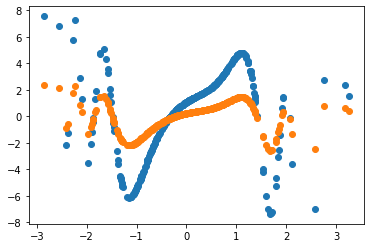

weight[0] shape:  torch.Size([5, 400])
bias[0] shape:  torch.Size([5, 1])
Relu Params[0]:  0.01
BN gamma[0]:  1.0919343224478912
BN beta[0]:  0.10000000149011642
weight[1] shape:  torch.Size([5, 5])
bias[1] shape:  torch.Size([5, 1])
Relu Params[1]:  0.01
BN gamma[1]:  1.0002533830882228
BN beta[1]:  0.10000000149011642
weight[2] shape:  torch.Size([400, 5])
bias[2] shape:  torch.Size([400, 1])
Relu Params[2]:  0.01
BN gamma[2]:  1.0352160314177057
BN beta[2]:  0.00872622385499952


In [120]:
if __name__ == '__main__':
    layers = (5, 5, 400)
    aFuncs = ('tanh', 'cos', 'linear')
    batchSize = 10
    nn1 = DNN(layers, aFuncs)
    nn1.setBackProp(PRelu=True, Norm=True)
    # 所有input全部变型成 m x 1 的形状
    testInput = torch.randn((20, 20), dtype=DTYPE['f64'], device=DEVICE[DEVICE_CHOICE])
    testInput = testInput.view(-1, 1)
    targetY = 5*torch.sin(testInput**3) + 2*torch.cos(2*testInput-1) - torch.tanh(testInput)
    # 生成权重和偏移
    nn1.genParam(testInput)
    nn1.printShape()
    # 训练
    nn1.train(testInput, targetY, nanInvestigate=0, epoch=1000)
    # 预测
    estimateY = nn1.predict(testInput)
    
    plt.scatter(testInput.cpu().numpy().flatten(), targetY.cpu().numpy().flatten())
    plt.scatter(testInput.cpu().numpy().flatten(), estimateY.cpu().numpy().flatten())
    plt.show()
    nn1.printShape()